In [156]:
import numpy as np
import sys
import os
from pathlib import Path
import itertools
import lib_liblinear.python.liblinearutil as lbl
import matplotlib.pyplot as plt

dir_path = Path.cwd()

print(dir_path)
sys.path.insert(0, dir_path)

/home/nikolaos/Workspaces/AML/Assignment_1_Programming/code


In [345]:
dataPath = os.path.join(dir_path, '../data')
letters = 'abcdefghijklmnopqrstuvwxyz'
# Load decode Input
decInputFile = os.path.join(dataPath, 'decode_input.txt')
with open(decInputFile, 'r') as f:
    inData = f.read().splitlines()
    inX = np.asarray(inData[0:12800], dtype = np.float)     # input is 100 letters @ 128 = 12800, or 0-12799. NOTE: Recall Python slice is [).
    inW = np.asarray(inData[12800:16128], dtype = np.float) # wieths are 26 * 128 = 3328, or 12800-16127
    inT = np.asarray(inData[16128:], dtype = np.float)      # The remaing are the transition probs.
print("Done reading! Sizes are X: {}, W:{},T: {}. Total: {}".format(inX.shape, inW.shape, inT.shape, inX.size+inW.size+inT.size))

Done reading! Sizes are X: (12800,), W:(3328,),T: (676,). Total: 16804


In [349]:
# Reshape arrays
# Reshape T to 26x26
inT = np.reshape(inT,(26,26)) 
inX = np.reshape(inX, (-1,128))
inW = np.reshape(inW, (128,-1))
print("Done reshaping! Sizes now are X: {}, W:{},T: {}".format(inX.shape, inW.shape, inT.shape))

Done reshaping! Sizes now are X: (100, 128), W:(128, 26),T: (26, 26)


In [118]:
# Max-Sum algorithm!
def crf_decoder(seq, w, t):
    # Init
    seqLen  = seq.shape[0]
    dataLen = w.shape[1]
    cMat    = np.zeros((seqLen, dataLen))
    bMat    = np.matmul(seq, w) # this gives the probability of observing each i standalone
    maxIdx  = np.zeros((seqLen, dataLen), dtype = np.int)
    decSeq  = []
    maxObj  = 0
    ci = np.zeros((26,26))
    
    # Get step 0 estimates
    step0    = np.matmul(seq[0,:], w)
    c1 = np.multiply(step0,t)      # the previous node potential x edje potenital for all i->j pairs
    maxIdx[0,:] = np.argmax(c1, axis = 0) #1x26 the max elem indexes
    c1 = c1[maxIdx[0,:],np.arange(c1.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
    cMat[0,:] = c1
    print("Input shapes: sequence: {}, weights: {}, T matrix:{}".format(seq.shape,w.shape,t.shape))
    
    # Perform a pass over steps 1-99 or 2-100 in 1-index notation!
    for i in range(1,seqLen):
        fi  = bMat[i,:]              # get likelihood of i observation being any letter as standalone 
        cYi = cMat[i-1,:]            # i-1 step's potential msg to this node i
        cYj = np.multiply(fi, t)     # mul the likelihood of each letter with all transition probs.
        maxIdx[i,:] = np.argmax(cYj, axis = 0) #1x26 the max elem indexes
        cYj = cYj[maxIdx[i,:],np.arange(cYj.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
        cYj = np.multiply(cYj, cYi)  # multiply current cYj = g_yj->yi* fj with pervious node's(i-1) msgs to yield the msg node i will wend to i+1
        cMat[i,:] = cYj              # store this node's msg, in order to send it to i+1 on next step!
        #if i == 1:
        #    print(cYj, cYj.shape, fi.shape)
    maxObj = np.max(cYj)             # max objective value is the maximum of the lasp step's messages or potentials Y_end 
    # Backward pass.
    # At each step, the element e at slot i is the label that most likely lead to the lable represented as i.
    # So at i.e if 95,5 = 11, then that means that the most probable letter that leads to f(idx 5) if letter 11 or l (label 11). All indexing is 0 based.
    decSeq     = np.zeros((seqLen,1), dtype = np.int)
    lastMax    = np.argmax(maxIdx[-1,:]) # get the most probable last element. use this to recurse and find the most prob sequence
    decSeq[-1] = lastMax
    for i in range(seqLen-2,-1,-1):
        #print("i is ", i, "decSeq of ", i+1, "is", decSeq[i+1])
        curMax = maxIdx[i,decSeq[i+1]]
        decSeq[i] = curMax
        
    return decSeq, maxObj
    
decSeq,maxObj = crf_decoder(inX, inW, inT)
print(maxObj)

Input shapes: sequence: (100, 128), weights: (128, 26), T matrix:(26, 26)
[7.78442958e-03 1.52115672e-02 1.20710706e-02 4.69876271e-03
 5.34670451e-01 1.14755986e-02 5.64371856e-02 3.31816960e-02
 4.00406494e-03 1.53669183e-01 4.88480308e-01 4.30666478e-05
 3.11189330e-01 7.07851358e-02 6.51891449e-02 1.29705870e-01
 1.68724845e-03 4.50357985e-01 6.23706302e-02 3.08509408e-03
 2.69362883e-02 3.39592362e-01 2.16999483e-01 3.78132364e-02
 1.30214979e-02 2.69906264e-01] (26,) (26,)


[]

In [70]:
# Write the decoded results to file
# Create results dir if ti does not exists (Python3.2+)
resPath = os.path.join(dir_path, 'results')
os.makedirs(resPath, exist_ok=True) 
# Form file name and write output
resFile = os.path.join(resPath, 'decode_output.txt')
np.savetxt(resFile, decSeq.astype(int),fmt='%d')

['f', 'p', 'd', 'k', 'j', 'o', 'i', 'u', 'y', 't', 'g', 'j', 'r', 'a', 'v', 'm', 'j', 'm', 's', 'u', 'n', 'h', 'y', 'n', 'p', 'w', 'h', 'm', 'e', 'v', 'j', 'k', 'z', 'p', 'n', 'b', 'i', 'r', 'b', 'z', 'g', 'v', 'm', 'k', 'd', 'd', 'i', 'e', 'x', 'r', 'f', 'e', 'y', 'm', 'm', 'x', 'c', 'o', 'm', 'r', 'x', 'x', 'x', 'n', 'c', 's', 'k', 'v', 'n', 'r', 'u', 'a', 'y', 'o', 'k', 'y', 'r', 'p', 'h', 'l', 'b', 'j', 't', 'w', 'l', 'u', 'w', 'p', 'q', 'a', 'i', 'g', 'r', 'f', 'v', 'u', 'd', 'z', 'a', 'p']


# Part 2
## Gradient Comptutation

In [442]:
def compute_dist(seq, w, t):
    dist = []
    # Init
    seqLen  = seq.shape[0]
    dataLen = w.shape[1]
    fMat    = np.zeros((seqLen, dataLen))
    oMat    = np.matmul(seq, w) # this gives the probability of observing each i standalone
    maxIdx  = np.zeros((seqLen, dataLen), dtype = np.int)
    decSeq  = []
    maxObj  = 0
    ci = np.zeros((26,26))
    
    # Get step 0 estimates
    step0    = np.matmul(seq[0,:], w)
    c1 = np.multiply(step0,t)      # the previous node potential x edje potenital for all i->j pairs
    c1 = c1[maxIdx[0,:],np.arange(c1.shape[1])] #1x26 select the max element, as indexed by maxIdx, for every column
    #cMat[0,:] = c1
    fMat[0,:] = 0
    print("Input shapes: sequence: {}, weights: {}, T matrix:{}".format(seq.shape,w.shape,t.shape))
    
    # Perform a pass over steps 1-99 or 2-100 in 1-index notation!
    # Recall that bmat is m x 26, each row a letter-wsie confidence vector. Similarly for cMat which is message of node i to i+1.
    for i in range(1,seqLen):
        fPrev  = oMat[i-1,:].reshape(-1,1)   # get likelihood of i observation being any letter as standalone,as a column vector
        fYPrev = fMat[i-1,:].reshape(-1,1)   # i-1 step's potential msg to this node i. f_y-1 in the assignment.
        cYi = np.exp(fPrev.transpose() + t + fYPrev.transpose())             # Turn weighted features into potentials.
        cYi = np.sum(cYi, axis =0) # sum the likelihood of each letter with all transition probs.
        if i == 1:
            print(cYi.shape)
            #pint(fPrev.shape,cYi, fPrev, t)
        #cYi = np.exp(cYi + fYPrev)             # Turn weighted features into potentials.
        cYi = np.log(cYi)
        #print(fPrev.shape,cYi.shape, cYPrev.shape)
        fMat[i,:] = cYi              # store this node's msg, in order to send it to i+1 on next step!
        
    
    bMat    = np.zeros((seqLen, dataLen)) # hold all the backward messages for the sequence, for each position s.
    # Backward pass.
    # --------------
    # Compute b_i's
    bMat[seqLen-1,:] = 0
    for i in range(seqLen-2, -1,-1):
        fNext  = oMat[i+1,:].reshape(-1,1) # get likelihood of i+1 observation being any letter as standalone 
        bYNext = bMat[i+1,:].reshape(-1,1) # i+1 step's potential msg to this node i. f_y-1 in the assignment.
        cYi = np.exp(fNext + t + bYNext) # sum the likelihood of each next letter letter i+1, along with the trans probs for each letter i in this step 
        cYi = np.sum(cYi, axis=1)        # Turn weighted features into potentials.
        cYi = np.log(cYi)
        bMat[i,:] = cYi              # store this node's msg, in order to send it to i+1 on next step!
        
    dist = fMat + bMat + oMat
    Zf = np.log(np.sum(np.exp(oMat[-1,:] + fMat[-1,:])))
    Zb = np.log(np.sum(np.exp(oMat[0,:] + bMat[0,:])))
    #print(Zf,Zb)
    # Locally normalize distribution computation
    dist /= np.sum(dist, axis = 1, keepdims =1)    
    distT = np.zeros((seqLen,t.shape[0], t.shape[1]))
    pYY = np.zeros((t.shape))
    for s in range(0, seqLen-1):
        #print(np.tile(fMat[s,:], (t.shape[0],1)).shape)
        termB = np.tile(oMat[s,:], (t.shape[0],1)) + np.tile(oMat[s+1,:].reshape(-1,1), (1,t.shape[0])) + t
        pYY = np.tile(fMat[s,:], (t.shape[0],1)) + np.tile(bMat[s+1,:].reshape(-1,1), (1,t.shape[0])) + termB
        print( pYY, pYY /np.sum(pYY, axis = 1, keepdims =1))
        distT[s,:,:] /= np.sum(pYY, axis = 1, keepdims =1)
    #for i in range(0, t.shape[0]:
    #    for j in range(0, t.shape[0]:
    #       distT = 
    print(distT) 
    return dist

In [443]:
#a = np.asarray([[1,2,3,4], [1,2,3,4]])
#b = np.asarray([5,6]).reshape(2,1)
#print(b.shape,a.shape)
#np.sum(b + a,axis=0)                
dist = compute_dist(inX, inW, inT)

Input shapes: sequence: (100, 128), weights: (128, 26), T matrix:(26, 26)
(26,)
[[8863.71115806]
 [8326.82208357]
 [7925.00970167]
 [8528.43507228]
 [7911.5250902 ]
 [8125.58943216]
 [8360.98298299]
 [8133.21555427]
 [8529.95983567]
 [8740.50288578]
 [8292.95861046]
 [8016.78647661]
 [8415.93601466]
 [8992.95173713]
 [8616.8088351 ]
 [8405.55153901]
 [8157.97589187]
 [8402.91765024]
 [8099.60621226]
 [8787.71611023]
 [8482.36974261]
 [8693.38010561]
 [8686.45624235]
 [8616.0066141 ]
 [8457.63831978]
 [8491.08850542]]
[[8872.8125566 ]
 [8321.60542585]
 [7921.45218535]
 [8540.54794746]
 [7883.06453227]
 [8133.88045173]
 [8352.45673925]
 [8151.50534639]
 [8536.55220038]
 [8741.0220316 ]
 [8252.2534578 ]
 [8024.39065721]
 [8457.81414753]
 [8995.38641268]
 [8600.06371766]
 [8356.73212602]
 [8167.41193943]
 [8379.16085339]
 [8117.49662187]
 [8814.22372062]
 [8493.97299562]
 [8744.61193631]
 [8653.35925457]
 [8632.84949199]
 [8455.40755643]
 [8461.25391395]]
[[8847.20176297]
 [8318.16346823]


# Part 3 Benchamrking with SVM!

In [238]:
# Part 3 Benchamrking with SVM!
modelLabels = ['CRF', 'SVM-HMM', 'SVM-MC']
# Define where svm_hmm lib and executables are
libPath = os.path.join(dir_path,'svm_hmm_linux64')
learnerPath = os.path.join(libPath, 'svm_hmm_learn')
testerPath  = os.path.join(libPath, 'svm_hmm_classify')
# data for the svms
svmTrainData = os.path.join(dataPath,'train_struct.txt')
svmTestData = os.path.join(dataPath,'test_struct.txt')
# make a file of true classes if they dont exists, without hte other stuff
sanTruthFile = os.path.join(dataPath, 'sanitizedTruth.txt')

# Get just the true labels and word indexes for all letters without features and the rest
if  not os.path.exists(sanThruthFile):
    #os.makedir(sanThruthFile)
    with open(svmTestData,'r') as o, open(sanTruthFile,'w') as s:
        d =[x.split(' ') for x in o.readlines()]   # split file into a list of lists of tokens
        sanLabel =[x[0] for x in d]                # get all labels. Its the first token of each line
        sanWIdx = [x[1].split(':')[1] for x in d]  # get all word indexes. It is the number after the : of the second token.
        # using list comprehension + zip() 
        # interlist element concatenation 
        sanData = [' '.join((i,j)) for i, j in zip(sanLabel, sanWIdx)]  
        print(sanData[0:30])
        s.write("\n".join(sanData))
        
gTruth = np.asarray([x.split(' ')[0] for x in open(sanTruthFile).readlines()]) # keep in mind that readlines retunrs the \n character

# transform data strcuture to LIBLINEAR format. Essentially we need to only remove the qid:x part
libSVMTrainData = os.path.join(dataPath, 'liblinear_svm_train.txt')
libSVMTestData  = os.path.join(dataPath, 'liblinear_svm_test.txt')
if not  os.path.exists(libSVMTestData):
    with open(svmTestData,'r') as i, open(libSVMTestData,'w') as o:
        d =[x.split(' ') for x in i.readlines()]   # split file into a list of lists of tokens
        for row in d:
            del row[1]
        #print(d[0:20])
        d = [' '.join(row[0:-1]) for row in d]
        o.write("\n".join(d))
        
if not os.path.exists(libSVMTrainData):
    with open(svmTrainData,'r') as i, open(libSVMTrainData,'w') as o:
        d =[x.split(' ') for x in i.readlines()]   # split file into a list of lists of tokens
        for row in d:
            del row[1]
        d = [' '.join(row[0:-1]) for row in d]
        #print(d[0:20])
        o.write("\n".join(d))    
d = 0

In [123]:
# C parameter for regulirization impact.
cParams = [1,2,5,10,100]
# array that holds accuracies for all plots. its going to be 2x3x|cParmas| = letter, word-wise accuracy x 3 models x number of examined c Params
# 1 dim: 0=letter-wise acc, 1 = word-wise acc
# 2 dim: 0=CRF, 1=SVM HMM, 2 = SVM-MC
# 3 dim: the various c Params
acc = np.zeros((2,3,len(cParams)))
for i,c in enumerate(cParams):
    learnOptions = '-c ' +str(c)
    svmHmmOutput = 'models/svm_hmm_'+str(c)+'.model'
    ## Create a command to call the binaries required
    cmd = ' '.join((learnerPath, learnOptions, svmTrainData, svmHmmOutput)) # ./svm_hmm_learn -c 5 -e 0.5 example7/declaration_of_independence.dat declaration.model 
    outFile = 'results/test_c_'+str(c)+'.outtags' 
    cmdTest = ' '.join((testerPath, svmTestData, svmHmmOutput, outFile)) 
    #y, x = lbl.svm_read_problem(svmTrainData, return_scipy = True) # y: ndarray, x: csr_matrix 
    #m = lbl.train(y[:200], x[:200, :], '-c 4')
    print("Executing: " ,cmd)
    exit = os.system(cmd) # returns the exit status
    os.system(cmdTest) # returns the exit status
    

NameError: name 'sanTruthFile' is not defined

In [240]:
# LIBLINEAR SVM for character by character multi-classification!
# Read the data!
yTrain, xTrain = lbl.svm_read_problem(libSVMTrainData, return_scipy = True) # y: ndarray, x: csr_matrix
yTest, xTest = lbl.svm_read_problem(libSVMTestData, return_scipy = True) # y: ndarray, x: csr_matrix
for i,c in enumerate(cParams):
    learnOptions = '-c ' +str(c)
    outFile = 'results/liblinear-mc_c_'+str(c)+'.outtags' 
    print("Executing LIBLINEAR Multi Classification for C: {} ".format(c))
    model   = lbl.train(yTrain, xTrain, learnOptions)
    p_label, p_acc, p_val = lbl.predict(yTest, xTest, model)
    acc[0,2,i] = p_acc[0]

Executing LIBLINEAR Multi Classification for C: 1 
Accuracy = 69.2992% (18155/26198) (classification)
Executing LIBLINEAR Multi Classification for C: 2 
Accuracy = 69.3106% (18158/26198) (classification)
Executing LIBLINEAR Multi Classification for C: 5 
Accuracy = 69.3412% (18166/26198) (classification)
Executing LIBLINEAR Multi Classification for C: 10 
Accuracy = 68.3754% (17913/26198) (classification)
Executing LIBLINEAR Multi Classification for C: 100 
Accuracy = 52.7254% (13813/26198) (classification)


In [247]:
acc[0,2,4] = 52.72

In [255]:
def compute_letterwise_accuracy(pred, gTruth = None):
    acc = 0
    #if isinstance(type(gTruth), typedir) and isinstance(type(pred),dir):
    if gTruth is None:
        gTruth = '../data/sanitizedTruth.txt'
    elif isinstance(gTruth, np.ndarray):
        trueClass = gTruth
    else:
        with open(gTruth, 'r') as g:
            trueClass = np.asarray([x.split(' ')[0] for x in g.readlines()]) # keep in mind that readlines retunrs the \n character
            
    with open(pred, 'r') as p:
        predClass = np.asarray(p.read().splitlines())
        
    acc = np.sum(predClass == trueClass) / trueClass.shape[0]
    return acc

def plot_accuracy(cParams, accs):
    """ DESCRIPTION: THis function will produce pltos for letter wands wordwise accuracy as a function of C params.
                     It expects ndArrays.   
        ARGUMENTS: xAxis(ndarray): values of C parameters.
                   yAxis(ndArray): acc values for the various models
    """
    plt.figure(figs)
    numOfPlots = 1
    if accs.ndim >1:
        numOfPlots = accs.shape[0] # ist dim has how many models exist!
    for n in range(numOfPlots):#
        print(n)
        plt.subplot(int('1'+str(numOfPlots)+str(n+1))) #index cannot be 0. As such increas it by 1 
        if accs.ndim <2:
            plt.plot(cParams, accs[:],marker = 'x')
            for x,y in zip(cParams, accs):                                       # <--
                plt.annotate('C: '+str(x), # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,7), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        else:
            plt.plot(cParams, accs[n,:], marker = 'x')
            for x,y in zip(cParams, accs[n,:]):                                       # <--
                plt.annotate('C: '+str(x), # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,7), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        
    plt.suptitle('Letterwise Accuracy vs C parameters')
    plt.xlabel('C Parameters')
    plt.ylabel('Accuracy')
    plt.show()

In [151]:
# Compute and print results
for i,c in enumerate(cParams):
    outFile = 'results/test_c_'+str(c)+'.outtags' 
    acc[0,1,i] = compute_letterwise_accuracy(outFile, gTruth = gTruth)
print("Accuracy results for SVM HMM, for C: {}:\n {}".format(cParams, acc[0,1,:]))

Accuracy results for SVM HMM, for C: [1, 2, 5, 10, 100]:
 [0.65222536 0.67982289 0.72070387 0.75043896 0.82345981]


0
1


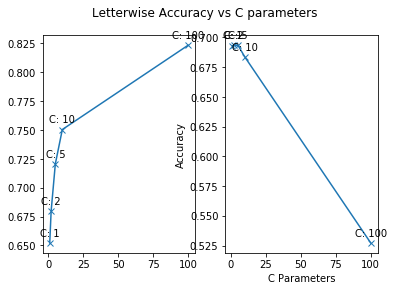

In [256]:
plot_accuracy(cParams, acc[0,1:,:])

array([0.6929, 0.6932, 0.6934, 0.6834, 0.5272])